In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
none_df = pd.read_hdf("data/none_stats.h5", "table")

In [3]:
none_df.head()

,user_id,product_id,indprod_dow_sin,indprod_dow_cos,indprod_hod_sin,indprod_hod_cos,indprod_num_orders,indprod_num_products_dw_8,indprod_num_products_dw_16,indprod_num_products_dw_32,...,indprod_day_proportion,user_hod_proportion,indprod_hod_proportion,indprod_dow_avg_diff,indprod_hod_avg_diff,user_dow_avg_diff,user_hod_avg_diff,user_distinct_products,reordered,user_mean_proportion_products
7904,1,None,9.749279e-01,-0.222521,7.818315e-01,0.623490,1,7.088227e-08,0.000266,0.016317,...,0.0,0.600000,1.0,-0.222521,1.000000,0.402664,0.967874,19,0.0,0.315789
7905,8942,None,-4.338837e-01,-0.900969,-2.449294e-16,1.000000,1,4.706454e-05,0.006860,0.082827,...,1.0,0.500000,1.0,1.000000,0.623490,0.915921,0.591232,39,0.0,0.365385
7906,11192,None,1.224647e-16,-1.000000,5.665539e-16,-1.000000,2,6.649579e-13,0.000001,0.001509,...,0.5,0.142857,0.0,0.900969,-0.623490,0.857034,-0.415271,38,0.0,0.243108
7907,12100,None,-4.338837e-01,-0.900969,-9.749279e-01,-0.222521,1,6.743496e-07,0.000821,0.028656,...,1.0,0.142857,0.0,1.000000,-0.900969,0.936239,0.846712,5,0.0,0.571429
7908,24280,None,8.994297e-01,-0.437066,9.749279e-01,-0.222521,9,3.308954e-03,0.063593,0.385819,...,0.0,0.055556,0.0,0.003535,0.623490,-0.214763,0.843701,15,0.0,0.133333


In [4]:
none_df['prediction'] = 0
#all_users = none_df.loc[none_df.eval_set == "train", "user_id"].unique()
#np.random.seed(1234)
#np.random.shuffle(all_users)


# In[53]:

#valid_set = pd.DataFrame({'user_id': all_users, 'validation_set': np.arange(0, all_users.shape[0]) % 11})


# In[56]:

#none_df = none_df.merge(valid_set, on='user_id', how='left')


# In[58]:

#none_df.validation_set = none_df.validation_set.fillna(-1)


In [6]:
none_df = none_df.merge((pd.read_csv('rawpredictions/glove_0.csv').groupby('user_id')
               .agg({'validation_set': np.mean}).reset_index()), 
              on='user_id')


In [7]:
predictions_df = none_df[["eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"]].copy()

In [8]:
import xgboost as xgb
prior_test = none_df.loc[none_df.eval_set == "test", :]
d_test = xgb.DMatrix(prior_test.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"], axis=1).as_matrix(),
                            feature_names=prior_test.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"], axis=1).columns.values.tolist(),
                     )

for v in range(10):
    predictions_df['prediction_'+str(v)] = 0
    prior_train = none_df.loc[(none_df.eval_set == "train") & (none_df.validation_set != v) & (none_df.validation_set != 10), :]
    prior_valid = none_df.loc[none_df.validation_set == v, :]
    prior_valid_2 = none_df.loc[none_df.validation_set == 10, :]

    d_train = xgb.DMatrix(prior_train.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"], axis=1).values,
                          feature_names=prior_train.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"], axis=1).columns.values.tolist(),
                          label=prior_train.reordered.as_matrix())
    d_valid = xgb.DMatrix(prior_valid.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"], axis=1).values,
                          feature_names=prior_valid.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"], axis=1).columns.values.tolist(),
                          label=prior_valid.reordered.as_matrix())
    d_valid_2 = xgb.DMatrix(prior_valid_2.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"], axis=1).values,
                            feature_names=prior_valid_2.drop(["prediction", "eval_set", "validation_set", "order_id", "reordered", "user_id", "product_id"], axis=1).columns.values.tolist(),
                            label=prior_valid_2.reordered.as_matrix())
    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    params['eta'] = 0.1
    params['max_depth'] = 6
    params['nthread'] = 12
    params['colsample_bytree'] = 1


    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=10)

    predictions_df.loc[none_df.eval_set == "test", 'prediction_' + str(v)] = bst.predict(d_test)
    predictions_df.loc[(none_df.eval_set == "train") & (none_df.validation_set != v) & (none_df.validation_set != 10), 'prediction_' + str(v)] = bst.predict(d_train)
    predictions_df.loc[none_df.validation_set == v, 'prediction_' + str(v)] = bst.predict(d_valid)
    predictions_df.loc[none_df.validation_set == 10, 'prediction_' + str(v)] = bst.predict(d_valid_2)


[0]	train-auc:0.820896	valid-auc:0.799549
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.83965	valid-auc:0.815274
[20]	train-auc:0.848057	valid-auc:0.818312
[30]	train-auc:0.85668	valid-auc:0.820744
[40]	train-auc:0.864751	valid-auc:0.822936
[50]	train-auc:0.872972	valid-auc:0.824976
[60]	train-auc:0.880301	valid-auc:0.825211
[70]	train-auc:0.88656	valid-auc:0.825772
[80]	train-auc:0.891683	valid-auc:0.826732
[90]	train-auc:0.895616	valid-auc:0.826586
[100]	train-auc:0.899052	valid-auc:0.826717
[110]	train-auc:0.902552	valid-auc:0.826306
[120]	train-auc:0.907151	valid-auc:0.826154
[130]	train-auc:0.911053	valid-auc:0.825903
Stopping. Best iteration:
[84]	train-auc:0.893081	valid-auc:0.826796

[0]	train-auc:0.819008	valid-auc:0.81464
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[

In [9]:
from sklearn.metrics import roc_auc_score

In [15]:
roc_auc_score(none_df.query('validation_set == 10').reordered, predictions_df.query('validation_set == 10').loc[:, 'prediction_0':'prediction_9'].mean(axis=1))

0.82897679277498193

In [18]:
none_df['prediction'] = predictions_df.loc[:, 'prediction_0':'prediction_9'].mean(axis=1)

In [19]:
raw_output = none_df.loc[:,['prediction', 'eval_set', 'validation_set', 'order_id', 'product_id', 'user_id', 'user_distinct_products', 'reordered']]
raw_output.to_csv("rawpredictions/nones.csv", index=False)


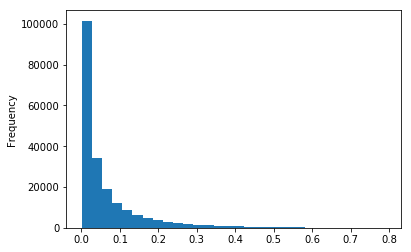

In [60]:
none_df.prediction.plot.hist(bins=30)